# Introducción

Este notebook tiene como objetivo realizar un proyecto data science en relación a problema de regresión con series temporales multivariantes, donde el principal objetivo será predecir valores futuros de la variable objetivo gracias a la información previa de dicha variable. Esto incluye:

1) Carga y peuqeña exploración/limpieza/transformación de los datos.

2) Visualización y análisis de los datos, y comprobación que la serie temporal objetivo no sea estacionaria.

3) Entrenar modelos de ML, visualizando gráficamente los resultados, y realizando una comparación mediante la evaluación de KPIs adecuados.

4) Predecir 100 valores futuros, para los cuáles no se tenga conocimiento de las variables regresoras.


En este caso, he seleccionado el dataset `Consumos de productos petrolíferos por grupo`, el cuál corresponde a un dataset de series temporales multivariantes sobre el consumo de dichos productos, en concreto el de 5 productos específicos.

Este dataset puede ser encontrado en la `Corporación de Reservas Estratégicas de Productos Petrolíferos y Corporación de Derecho Público tutelada por el Ministerio para la Transición Ecológica y el Reto Demográfico.` [LINK](https://www.cores.es/es/estadisticas). En concreto se ha descargado el caso de `Productos Petrolíferos, Consumo de producto petrolíferos por grupo, 1969`. (Veáse imágen a continuación).


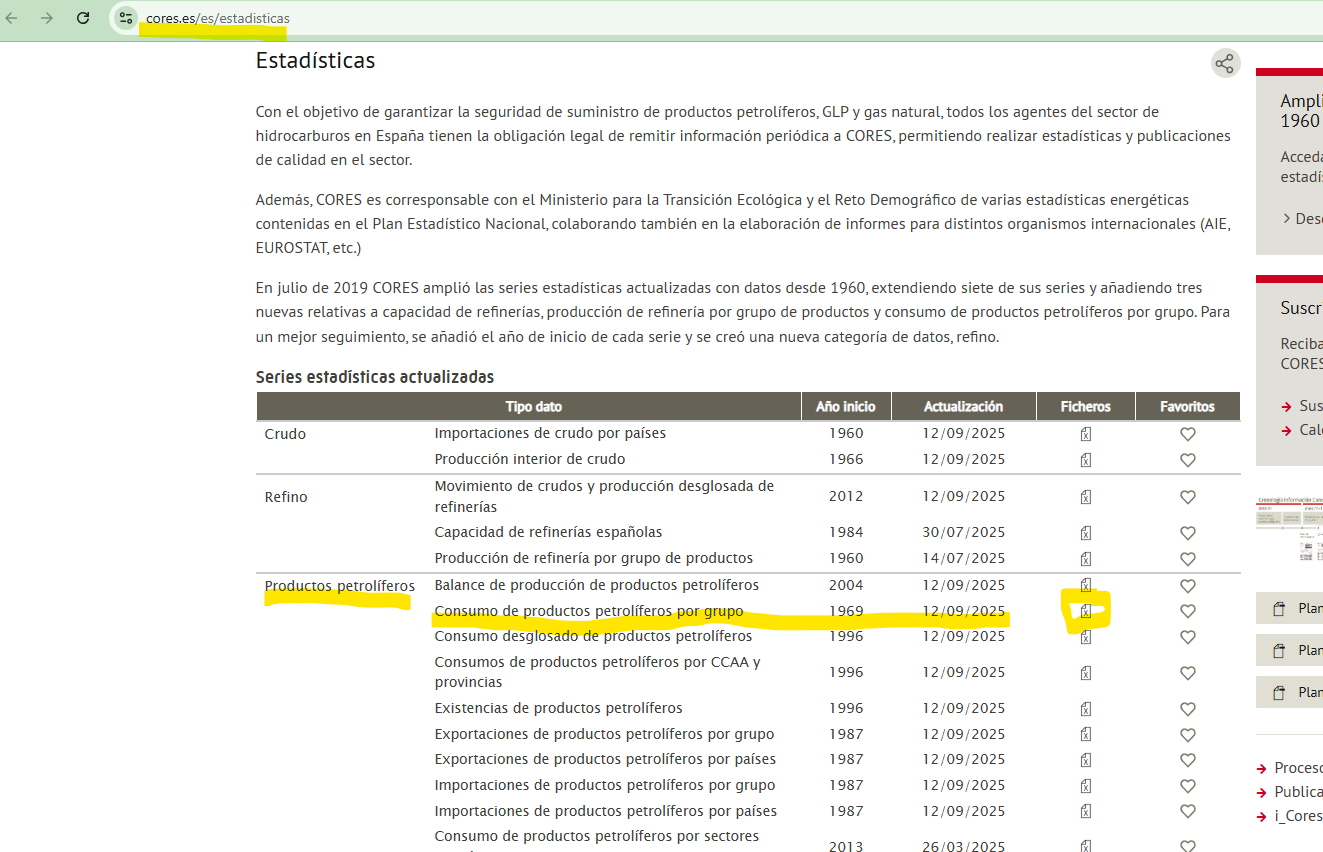


1) Importacion de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

2) Cargamos el dataset y hacemos una pequeña exploración\limpieza\transformación del mismo.

In [2]:
df = pd.read_excel('../data/consumos-pp-por-grupo.xlsx', sheet_name='Consumos', skiprows=4)
df.head(20)

,Año,Mes,GLP's,Gasolinas,Querosenos,Gasóleos,Fuelóleos,Otros Productos,Total
0,1969,enero,1.336151e+05,1.668752e+05,1.232578e+05,4.011853e+05,9.125834e+05,NaN,NaN
1,1969,febrero,1.267485e+05,1.554668e+05,1.146826e+05,3.853600e+05,8.518778e+05,NaN,NaN
2,1969,marzo,1.077958e+05,1.849837e+05,1.099701e+05,4.189556e+05,8.738843e+05,NaN,NaN
3,1969,abril,9.668316e+04,2.023198e+05,1.087979e+05,4.389755e+05,7.554901e+05,NaN,NaN
4,1969,mayo,7.950624e+04,2.062592e+05,1.035541e+05,4.674519e+05,7.299636e+05,NaN,NaN
5,1969,junio,7.209124e+04,2.084118e+05,1.047919e+05,4.635656e+05,6.553138e+05,NaN,NaN
6,1969,julio,7.251522e+04,2.657367e+05,1.099920e+05,5.039469e+05,7.037090e+05,NaN,NaN
7,1969,agosto,6.960126e+04,2.822870e+05,1.085870e+05,4.934954e+05,7.572962e+05,NaN,NaN
8,1969,septiembre,8.010126e+04,2.322259e+05,1.092059e+05,4.747791e+05,8.134778e+05,NaN,NaN
9,1969,octubre,9.084798e+04,2.171339e+05,1.091462e+05,4.931002e+05,8.245769e+05,NaN,NaN


Visualizando el dataset, podemos observar que para cada año, tenemos 12 muestras, una por cada mes, más una que recuenta el total, por lo que debemos eliminar dicha muestra para dicho proyecto. Al tener dos columnas referentes a la fecha (Año y Mes), debemos convertirlas en una única columna de tipo `datetime`.

Además, tenemos dos columnas que no aportan información (`Otros Productos` y `Total`), por lo que las eliminaremos.

In [3]:
# eliminamos variables que no tienen datos
df = df.drop(["Otros Productos", "Total"], axis = 1)

# eliminamos las filas que no son necesarias (totales anuales)
df = df[df["Mes"] != "total"].reset_index(drop = True)

# eliminamos muestras con valores faltantes, ya que los ultimos meses de 2025 añaden NaN al no estar recogidos aún en el excel
df = df.dropna()

# convertimos las columnas de año y mes en una única tipo datetime
meses_map = {
    "enero": 1, "febrero": 2, "marzo": 3, "abril": 4, "mayo": 5, "junio": 6,
    "julio": 7, "agosto": 8, "septiembre": 9, "octubre": 10, "noviembre": 11, "diciembre": 12}

df['Mes_num'] = df['Mes'].map(meses_map)

df['Fecha'] = pd.to_datetime(
    df.rename(columns = {"Año": "year", "Mes_num": "month"})[['year', 'month']].assign(day = 1))

df

,Año,Mes,GLP's,Gasolinas,Querosenos,Gasóleos,Fuelóleos,Mes_num,Fecha
0,1969,enero,133615.096191,166875.212891,123257.809022,4.011853e+05,912583.420212,1,1969-01-01
1,1969,febrero,126748.474121,155466.810547,114682.576706,3.853600e+05,851877.811491,2,1969-02-01
2,1969,marzo,107795.809082,184983.669922,109970.079579,4.189556e+05,873884.293349,3,1969-03-01
3,1969,abril,96683.159668,202319.816406,108797.925521,4.389755e+05,755490.116979,4,1969-04-01
4,1969,mayo,79506.238037,206259.152344,103554.078421,4.674519e+05,729963.600918,5,1969-05-01
...,...,...,...,...,...,...,...,...,...
674,2025,marzo,196286.040000,524937.820000,578967.460000,2.548237e+06,701645.010000,3,2025-03-01
675,2025,abril,169623.850000,587898.830000,623924.480000,2.561029e+06,709563.600000,4,2025-04-01
676,2025,mayo,133826.580000,592299.870000,664001.280000,2.629101e+06,594046.100000,5,2025-05-01
677,2025,junio,112681.920000,613658.390000,693984.830000,2.578783e+06,546569.490000,6,2025-06-01


Podemos ver como tenemos datos desde Enero de 1969 hasta Julio de 2005. Es decir deberíamos tener 12 x 56 (56 años completo con 12 meses de datos) + 7 (ultimo año), que corresponde con 679 valores, por lo que vamos a ver si esto coincide con el número de muestras presentes en el dataset

In [4]:
df = df.drop(["Año", "Mes", "Mes_num"], axis=1)
num_days = (df['Fecha'].max() - df['Fecha'].min()).days
num_muestras = 12*56+7
print("Número de muestras esperado:", num_muestras)
print("Número de muestras en el dataset:", df.shape[0])
if num_muestras == df.shape[0]:
    print("El número de muestras coincide con el esperado")
else:
    print("El número de muestras no coincide con el esperado")

Número de muestras esperado: 679
Número de muestras en el dataset: 679
El número de muestras coincide con el esperado


3) Visualización de los datos y análisis exploratorio, con el objetivo de entender las relaciones entre las variables presetes en el dataset, así como la estacionalidad de la serie temporal objetivo (`Gasolinas`), que se refiere al consumo de gasolina.

Primero, ponemos como indice del dataframe la columna fecha, para facilitar todo el proceso de visualización.

In [5]:
df.set_index('Fecha', inplace = True)

Visualizamos las series temporales. Enfásis en que nuestro objetivo va a ser predecir el consumo de gasolina (lo he elegido así por ínteres propio ya que mi vehículo es de gasolina, y quiero saber si cada vez se consume más de dicho producto, lo cuál podría significar que los vehículos de gasolina siguen siendo una buena opción frente a otras alternativas como diesel y électricos)

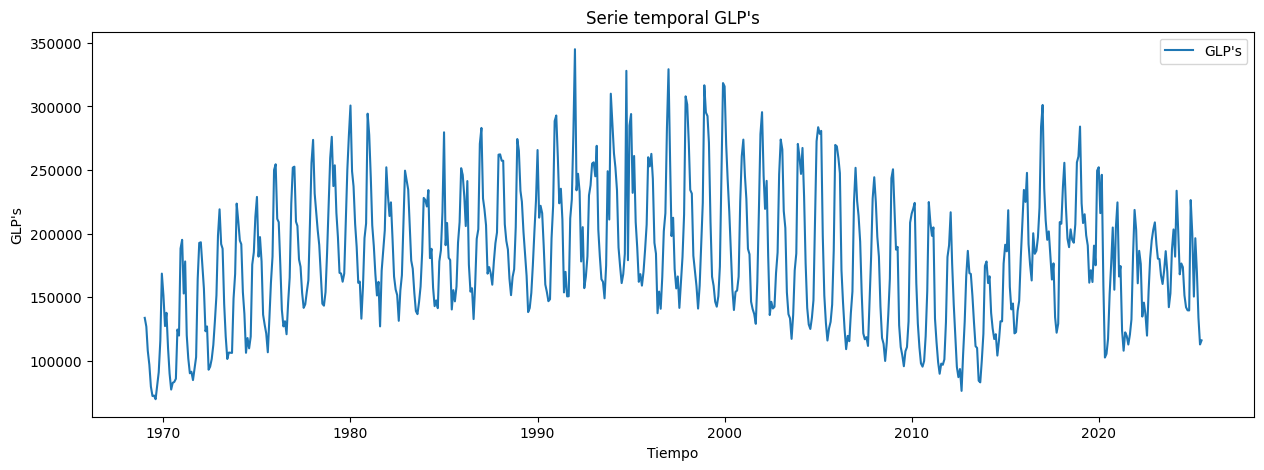

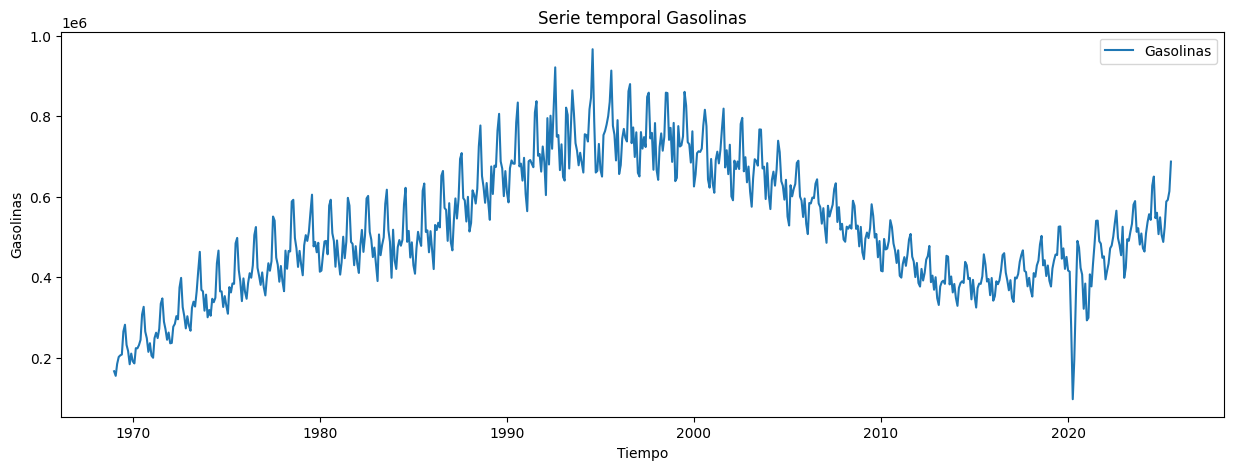

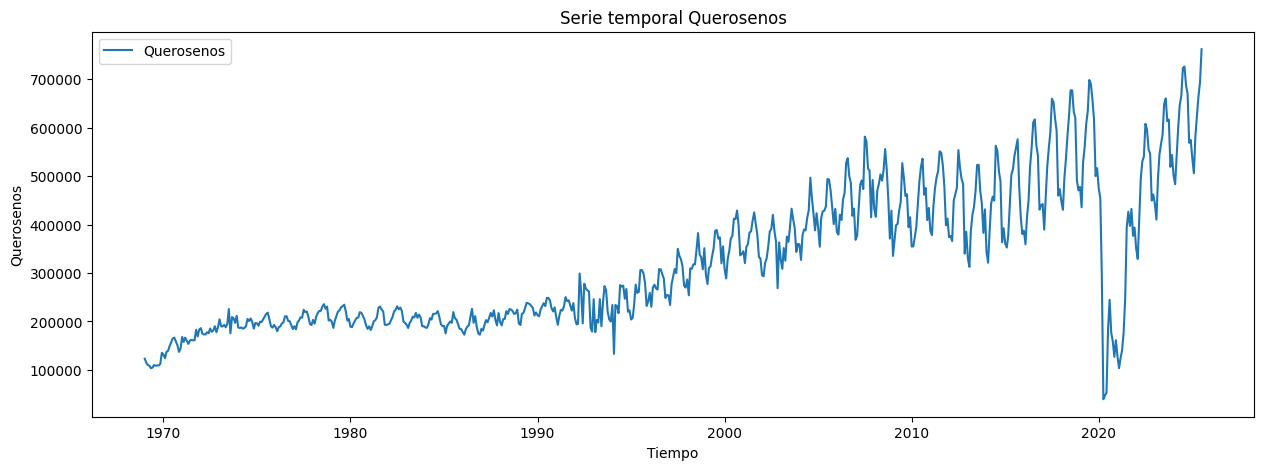

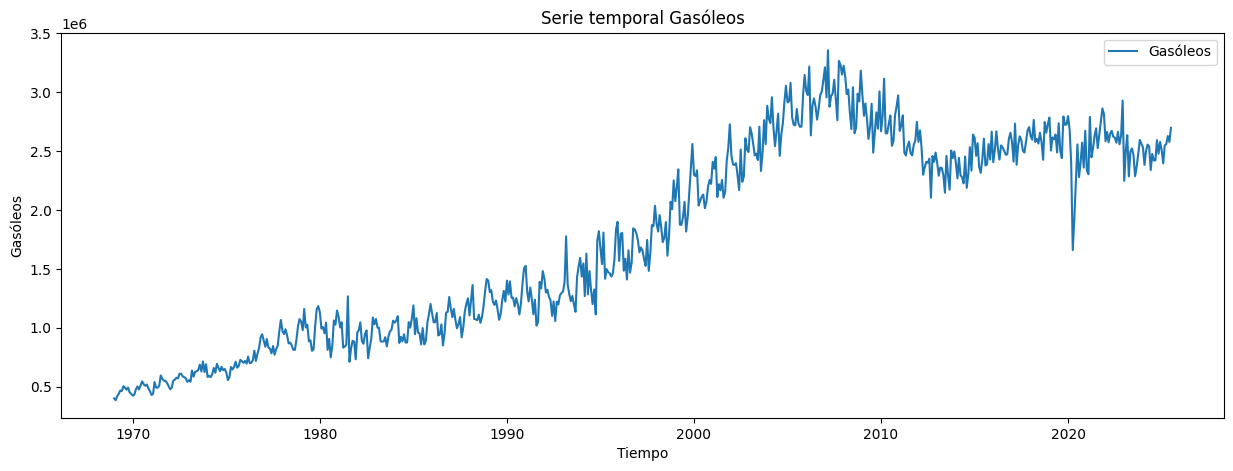

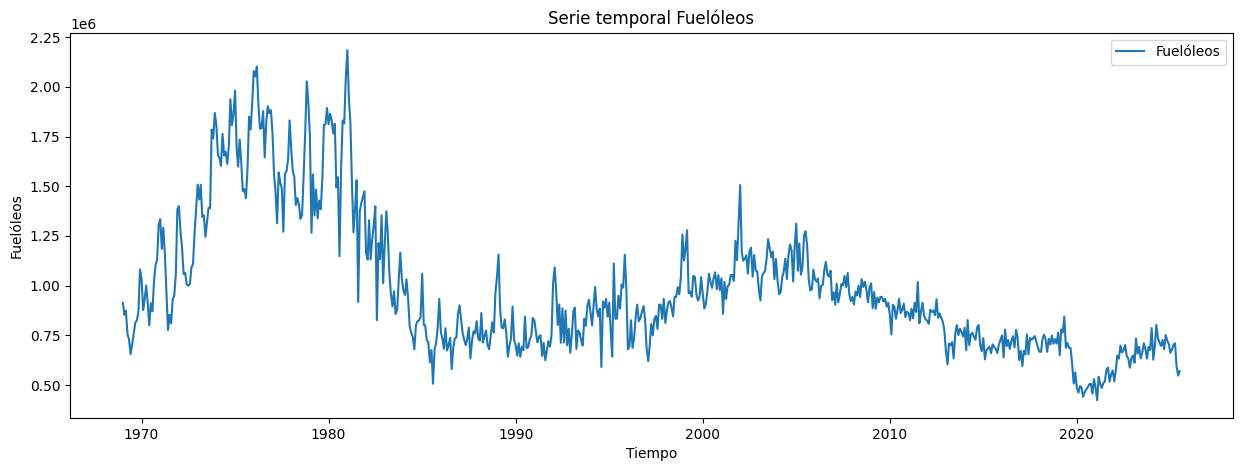

In [6]:
for col in df.columns:
    plt.figure(figsize = (15,5))
    plt.plot(df[col], label = col)
    plt.title(f"Serie temporal {col}")
    plt.xlabel("Tiempo")
    plt.ylabel(col)
    plt.legend()
    plt.savefig(f'../figures/time_serie_{col}.png')
    plt.show()

Por los gráficos individuales, no se ve gran cosa, por lo que algo que particularmente me gusta hacer es ver todas las series temporales en un mismo gráfico mediante `plotly`, para mayor flexibilidad, es decir, posibilidad de hacer zoom, de seleccionar la serie/series que quiero visualizar etc, con el objetivo de ver si hay alguna relación entre ellas.

In [7]:
fig = go.Figure()
for col in df.columns:
    fig.add_trace(go.Scatter(x = df.index, y = df[col], mode='lines', name = col))
 

fig.update_layout(title='Serie temporal del dataset multivariante',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',)
fig.write_image("../figures/multivariate_time_series_plotly.png")
fig.show()

Con este gráfico podemos observar que las series temporales han presentado ciertas tendencias, pero en algunos casos no se ha mantenido en el tiempo. Si es verdad, que parece ser que en los ultimos años (desde el covid) el consumo de gasolina vuelve a estar en cierta tendencia ascendiente. No se observa gran relación entre el consumo de los distintos productos. Veámoslo calculando la correlación entre las distintas series.

In [8]:
df.corr()

,GLP's,Gasolinas,Querosenos,Gasóleos,Fuelóleos
GLP's,1.000000,0.215774,-0.148830,0.073379,0.106596
Gasolinas,0.215774,1.000000,0.119761,0.186979,-0.165159
Querosenos,-0.148830,0.119761,1.000000,0.805677,-0.354557
Gasóleos,0.073379,0.186979,0.805677,1.000000,-0.437067
Fuelóleos,0.106596,-0.165159,-0.354557,-0.437067,1.000000


Como podemos ver, la variable objetivo (consumo de gasolina) no parece tener una correlación significativa con el consumo del resto de productos. En cambio el consumo de otros productos si parece estar relacionado, por ejemplo entre el del `Gasóleo` y el del `Querosenos`, los cuáles tienen una alta correlación positiva (a mayor consumo de uno, se supone que mayor consumo del otro). Algunos otros productos tambien parecen tener cierta correlación inversa.




Comprobamos ahora, si la serie temporal objetivo tiene estacionalidad. Primero, vamos a observarlo mediante técnicas de descomposición.

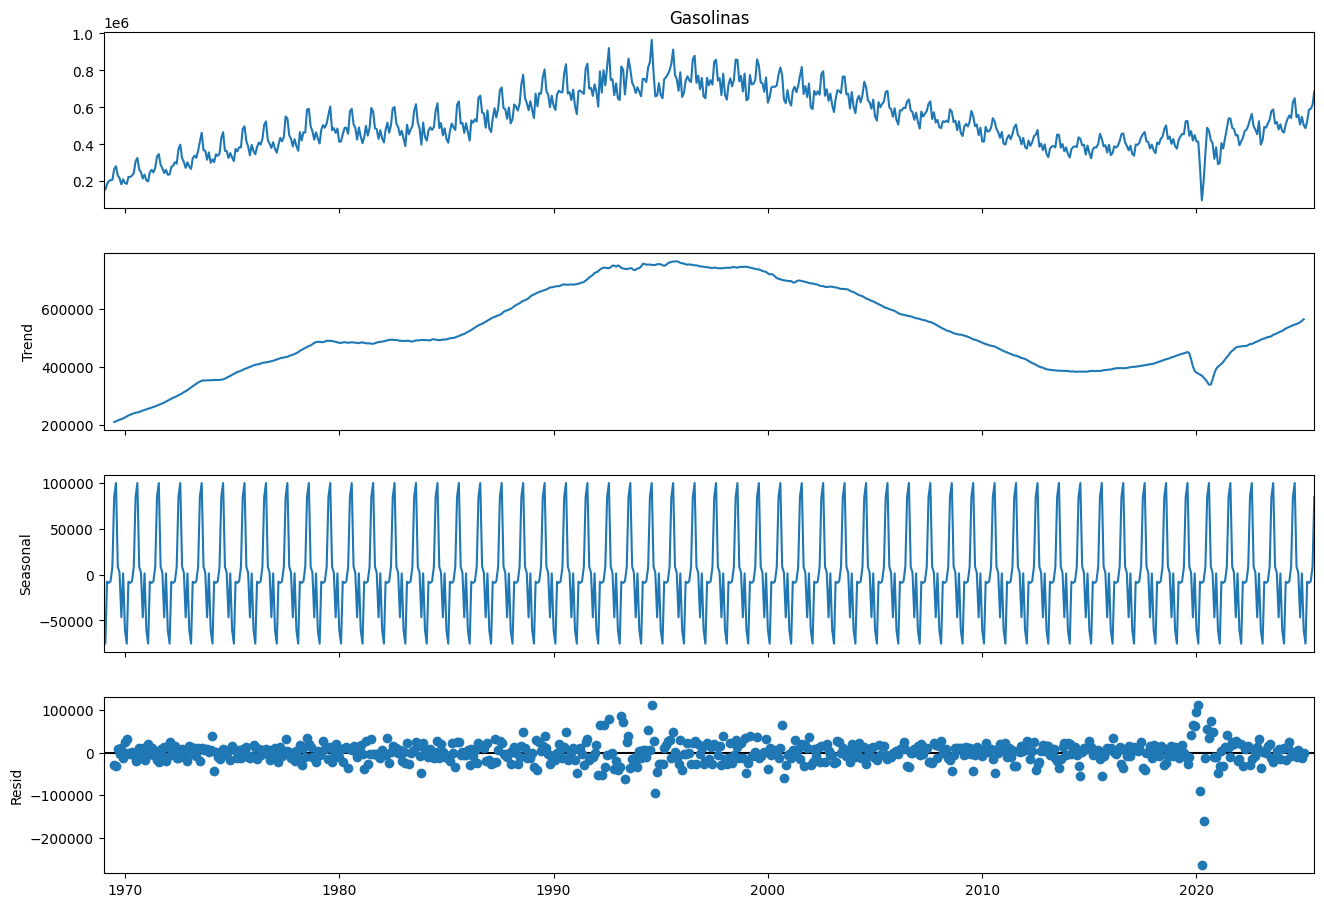

In [9]:
decomposition = seasonal_decompose(df["Gasolinas"], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

Ya con este gráfico de descomposición podemos observar que:

- Ha existido cierta tendencia en el consumo de dicho producto, primero con una tendencia creciente, posteriormente decreciente, y a partir del covid se está recuperando la tendencia creciente.

- Se observa un patrón muy fuerte y regular, lo cuál tambien puede verse como indicativo de que la serie en bruto no es estacionaria.

Mediante el contraste de Dickey-Fuller aumentado (ADF), podemos comprobar si la serie temporal es estacionaria o no con significancia estadística. La hipótesis nula del test ADF es que la serie temporal tiene una raíz unitaria, lo que implica que no es estacionaria. Si el p-valor no es menor cierto nivel significancia (he utilizado 0.05), no tenemos suficiente evidencia para rechazar la hipótesis nula y podemos concluir que la serie temporal es no estacionaria.

In [10]:
result = adfuller(df["Gasolinas"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print("La serie temporal es estacionaria (p-valor < 0.05)")
else:
    print("La serie temporal no es estacionaria (p-valor > 0.05)")

ADF Statistic: -1.910793
p-value: 0.327001
La serie temporal no es estacionaria (p-valor > 0.05)


En definitiva, podemos concluir que la serie original de la variable objetivo no es estacionaria. Ahora el objetivo será diferenciar la serie temporal hasta alcanzar la estacionariedad, con el objetivo de poder construir posteriormente modelos de predicción efectivos.

El patrón recurrente parece ser de cada 12 meses sugiriendo una estacionalidad anual (como se puede ver en el gráfico de la estacionalidad), lo que me sugiere que aplicando una diferenciación de orden 1 y diferenciación estacional, deberiamos obtener estacionariedad.

In [11]:
datosgasolinadiff = df["Gasolinas"].diff().diff(12).dropna()
result = adfuller(datosgasolinadiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print("La serie temporal es estacionaria (p-valor < 0.05)")
else:
    print("La serie temporal no es estacionaria (p-valor > 0.05)")

ADF Statistic: -10.424710
p-value: 0.000000
La serie temporal es estacionaria (p-valor < 0.05)


Efectivamente. Podemos pasar a aplicar modelos de predicción.

4) Entrenar y evaluar con kpis distintos modelos de ML para predicción de futuros instantes de tiempo

Vamos a hacer la división de los datos en train y valid, dejando los últimos 7 años de validación y el resto para entrenamiento, con el objetivo de poder evaluar distintos modelos y ver con cuál de ellos nos quedamos para predecir los próximos 100 valores, para los cuáles no se conoce información de las variables regresoras.

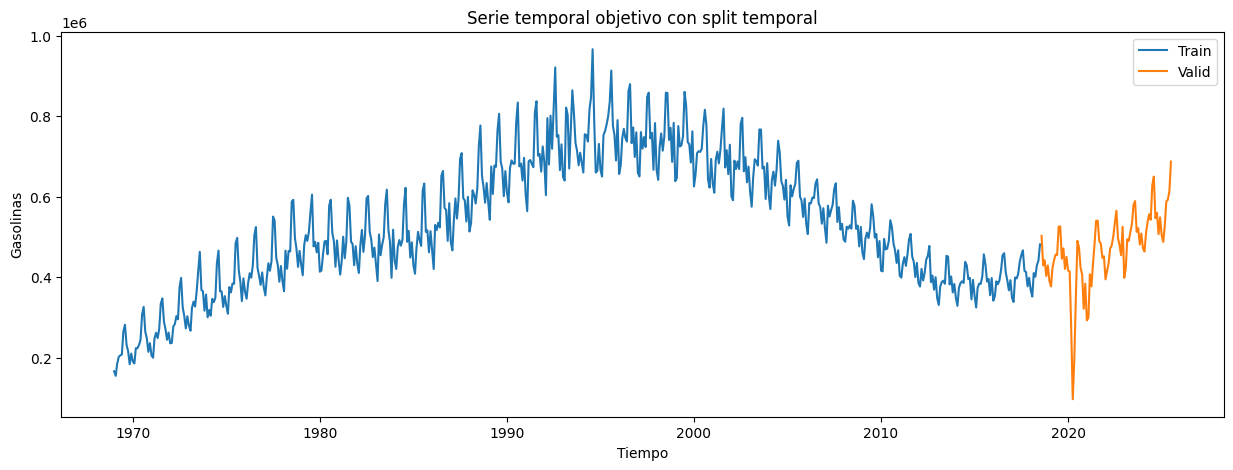

In [12]:
fin_train = '2018-07-01 23:59:59'
df_train = df.loc[:fin_train]
df_valid = df.loc[fin_train:]

plt.figure(figsize=(15,5))
plt.plot(df_train["Gasolinas"], label = "Train")
plt.plot(df_valid["Gasolinas"], label = "Valid")
plt.title(f"Serie temporal objetivo con split temporal")
plt.xlabel("Tiempo")
plt.ylabel("Gasolinas")
plt.legend()
plt.savefig(f'../figures/objective_time_serie_split.png')
plt.show()

Vamos a comparar ahora dos modelos de predicción: Suavizado exponencial de Holt Winter y SARIMA (ya que ARIMA al haber estacionalidad no tiene sentido aplicarlo), usando la libreria `statsmodels`. Estaría interesante probar un modelo SARIMAX (SARIMA pero teniendo en cuenta variables exógenas, es decir los valores de las otras series temporales), pero un requisito del proyecto es predecir 100 valores futuros sin conocer valores de las variables regresoras, por lo que con el modelo SARIMAX, necesitariamos aportar valores de los otros datos también para la predicción final.


c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



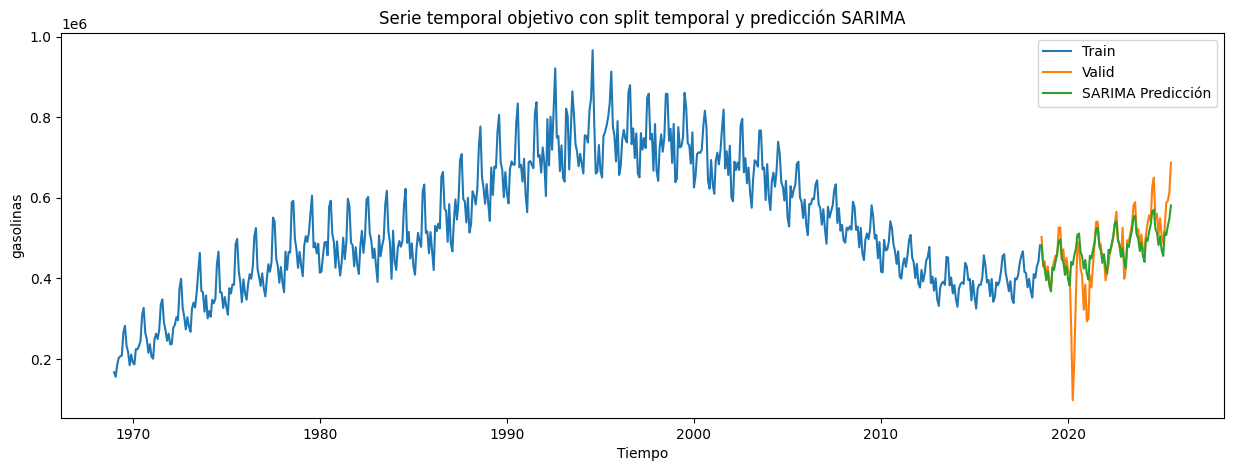

In [13]:
kpis_models = {}

sarima = ARIMA(endog = df_train["Gasolinas"], order = (1, 1, 0), seasonal_order = (1, 1, 0, 12))
sarima_results = sarima.fit()
sarima_pred = sarima_results.forecast(steps = len(df_valid["Gasolinas"]))
 
plt.figure(figsize=(15,5))
plt.plot(df_train["Gasolinas"], label="Train")
plt.plot(df_valid["Gasolinas"], label="Valid")
plt.plot(sarima_pred, label="SARIMA Predicción")
plt.title(f"Serie temporal objetivo con split temporal y predicción SARIMA")
plt.xlabel("Tiempo")
plt.ylabel("gasolinas")
plt.legend()
plt.savefig(f'../figures/objective_time_serie_valid_SARIMA.png')
plt.show()

kpis_models['SARIMA'] = {
    'AIC': sarima_results.aic,
    'BIC': sarima_results.bic,
    'MAE': mean_absolute_error(df_valid["Gasolinas"], sarima_pred)
}


c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



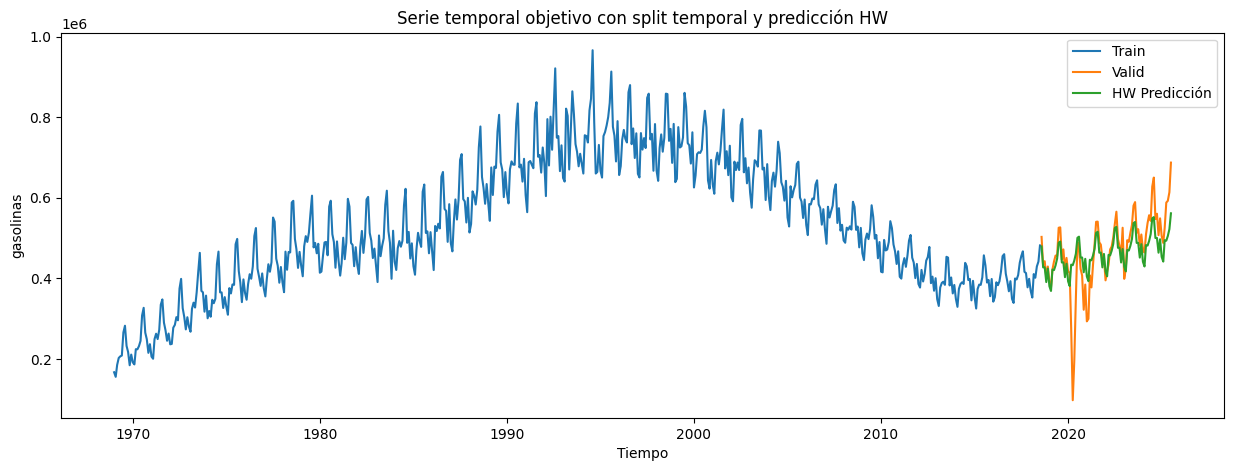

In [14]:
holt_model = ExponentialSmoothing(df_train["Gasolinas"], trend = 'add', seasonal = 'add', seasonal_periods = 12)
holt_fit = holt_model.fit()
holt_pred = holt_fit.forecast(len(df_valid["Gasolinas"]))

plt.figure(figsize=(15,5))
plt.plot(df_train["Gasolinas"], label="Train")
plt.plot(df_valid["Gasolinas"], label="Valid")
plt.plot(holt_pred, label="HW Predicción")
plt.title(f"Serie temporal objetivo con split temporal y predicción HW")
plt.xlabel("Tiempo")
plt.ylabel("gasolinas")
plt.legend()
plt.savefig(f'../figures/objective_time_serie_valid_HW.png')
plt.show()

kpis_models['Holt-Winters'] = {
    'AIC': holt_fit.aic,
    'BIC': holt_fit.bic,
    'MAE': mean_absolute_error(df_valid["Gasolinas"], holt_pred)
}



Cuando visualizamos las predicciones de ambos modelos sobre la serie temporal, no se aprecia de manera nítida cuál es superior, ya que las trayectorias estimadas son relativamente similares y las diferencias en ajuste quedan enmascaradas por la escala de la serie. Es aquí donde los KPIs pueden ser fundamentales para elegir un modelo o otro. Vamos a ver los kpis para los dos modelos

In [15]:
results_df = pd.DataFrame(kpis_models).T
print(results_df)
results_df.to_csv('../results/KPIs_comparacion_modelos.csv')

                       AIC           BIC           MAE
SARIMA        13595.440763  13608.540174  37774.809261
Holt-Winters  11909.117644  11979.334626  43722.590308


Al comparar los modelos ajustados, observamos diferencias claras en los indicadores de calidad. En primer lugar, si atendemos a los criterios de información (AIC y BIC), el modelo Holt-Winters obtiene valores más bajos. Esto significa que, desde el punto de vista del equilibrio entre ajuste y complejidad, Holt-Winters es el modelo que parece que mejor se ajusta a los datos.

Por otro lado, al mirar el MAE en validación, que mide directamente la capacidad predictiva sobre datos no vistos por el entrenamiento, ocurre lo contrario: SARIMA presenta un error más bajo, sugeriendo, aunque Holt-Winters tenga mejores criterios de información, que el modelo SARIMA es capaz de predecir con más precisión en nuevos datos.

Mi elección sería quedarnos con SARIMA como modelo final, porque el objetivo principal de este tipo de aplicación suele ser la predicción de valores futuros, y ahí muestra un desempeño superior según el MAE, a pesar de que el AIC/BIC sean más altos para el otro modelo.

Por ello, se procede a realizar la predicción de 100 (próximos 8 años aproximadamente) futuros valores del consumo de gasolina en españa, por lo que se va a reentrenar con toda la serie histórica completa (train + validación) para no perder información, y después generar los próximos 100 valores.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cimagroup\Documents\Repositorios\VTD-DataScience-2\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No f

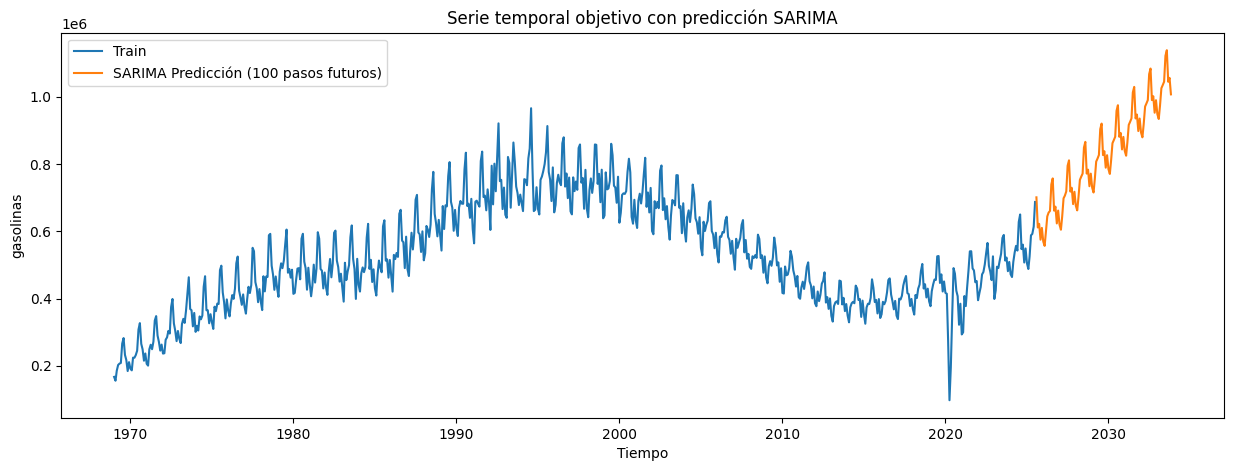

In [16]:
sarimafinal = ARIMA(endog = df["Gasolinas"], order = (1, 1, 0), seasonal_order = (1, 1, 0, 12))
sarimafinal_results = sarimafinal = ARIMA(endog = df["Gasolinas"], order = (1, 1, 0), seasonal_order = (1, 1, 0, 12)).fit()
sarimafinal_pred = sarimafinal_results.forecast(steps=100)

plt.figure(figsize=(15,5))
plt.plot(df["Gasolinas"], label="Train")
plt.plot(sarimafinal_pred, label="SARIMA Predicción (100 pasos futuros)")
plt.title(f"Serie temporal objetivo con predicción SARIMA")
plt.xlabel("Tiempo")
plt.ylabel("gasolinas")
plt.legend()
plt.savefig(f'../figures/objectie_time_serie_future_SARIMA.png')
plt.show()

Ahora al haber sido reentrenado con toda la serie, parece ser que el modelo SARIMA predice que el consumo de la gasolina va a seguir una tendencia ascendente muy clara.

Obviamente estos resultados pueden ser más precisos, y mejores en cuánto a rendimiento, utilizando métodos más actuales como el `Profeta`, o mediante búsqueda de parámetros para crear el modelo SARIMA, necesitando un análisis más exhaustivo.

5) Guardamos el modelo, lo cargamos como si estuviera en producción, y generamos nuevas predicciones futuras.

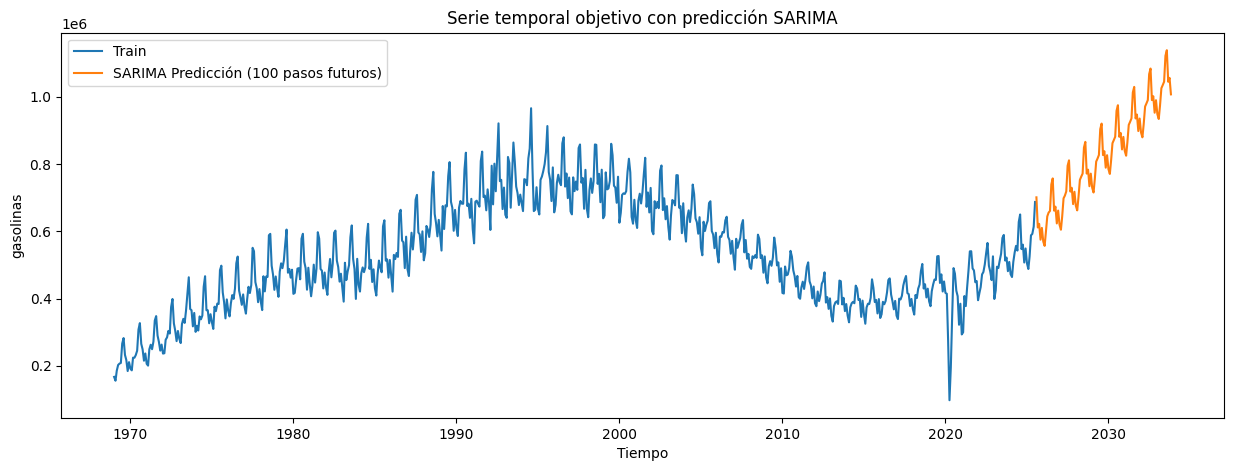

In [17]:
import joblib

joblib.dump(sarimafinal_results, "../results/model_sarima.pkl")
model_loaded = joblib.load("../results/model_sarima.pkl")
new_preds = model_loaded.forecast(steps=100)

plt.figure(figsize=(15,5))
plt.plot(df["Gasolinas"], label="Train")
plt.plot(new_preds, label="SARIMA Predicción (100 pasos futuros)")
plt.title(f"Serie temporal objetivo con predicción SARIMA")
plt.xlabel("Tiempo")
plt.ylabel("gasolinas")
plt.legend()
plt.savefig(f'../figures/production_futurepredictions_sarima.png')
plt.show()